In [1]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from typing import List, Union
from collections import OrderedDict
import itertools
from qiskit.quantum_info import Statevector
import multiprocessing as mp
from math import pi
from scipy.special import logsumexp

In [2]:
def final_circuit(circuit, data, params):
    d = len(params)
    layers = d//num_qubits
    
    for i in range(num_qubits):
        circuit.h(i)
    for j in range(layers-1):
        for i in range(num_qubits):
            circuit.rz(data[i],i)
            circuit.ry(data[i+2],i)
            #print(i+num_qubits*j)
            circuit.ry(params[i+num_qubits*j], i)
        circuit.cx(0,1)
    
    for i in range(num_qubits):
        circuit.rz(data[i],i)
        circuit.ry(data[i+2],i)
        #print(i+num_qubits*(layers-1))
        circuit.ry(params[i+num_qubits*(layers-1)], i)

In [3]:
def _parity():
    y1 = []
    y2 = []
    basis_states = [list(i) for i in itertools.product([0, 1], repeat=num_qubits)]
    for idx, k in enumerate(basis_states):
        parity = sum(int(k[i]) for i in range(len(k)))
        if parity % 2 == 0:
            y1.append(idx)
        else:
            y2.append(idx)
    return {'y1': y1, 'y2': y2}

In [4]:
def get_probabilities(params, x):
    
    def get_probs(inds, thetas, datas, results):
        for i, theta, data in zip(inds, thetas, datas):
            circuit = QuantumCircuit(2)
            circ_ = final_circuit(circuit, data, theta)
            result = sv.evolve(circuit)
            start = i * 2**num_qubits
            end = (i+1) * 2**num_qubits
            results[start:end] = result.probabilities()
    params = np.array(params)
    x = np.array(x)      
    
     # specify number of parallel processes
    num_processes = 2

        # construct index set per process
    indices = []
    start = 0
    size = len(x) // num_processes
    for i in range(num_processes-1):
        end = start + size
        indices += [list(range(start, end))]
        start = end
    indices += [list(range(end, len(x)))]

        # initialize shared array to store results (only supports 1D-array, needs reshaping later)
    results = mp.Array('d', (len(x) * 2**num_qubits))

        # construct processes to be run in parallel
    processes = [mp.Process(target=get_probs, args=(inds, params[inds], x[inds], results))
                     for inds in indices]

    for p in processes:
        p.start()
    for p in processes:
        p.join()
    probabilities = []
    num_probs = 2**num_qubits
    for i in range(len(x)):
        start = i * num_probs
        end = (i+1) * num_probs
        probabilities += [results[start:end]]

    return probabilities

In [5]:
def get_gradient(params, x):
    grads = []
    qc_plus = []
    qc_minus = []
    zeros = np.zeros(np.shape(params))
    for i in range(d):
        #print(i)
        zeros[:, i] = np.pi / 2.
        qc_plus += [get_probabilities(params+zeros, x)]
        qc_minus += [get_probabilities(params-zeros, x)]
        zeros[:, i] = 0
        grads.append((np.array(qc_plus[i]) - np.array(qc_minus[i])) * 0.5)
    grads = np.array(grads)
    #print(grads)
        # reshape the dp_thetas
    full = np.zeros((len(x), d, 2**num_qubits))
    for j in range(len(x)):
        row = np.zeros((d, 2**num_qubits))
        for i in range(d):
            tensor = grads[i]
            row[i] += tensor[j]
        full[j] += row
    return full

In [6]:
def forward(params, x):
    def get_probs(inds, thetas, datas, results):
        for i, theta, data in zip(inds, thetas, datas):
            circuit = QuantumCircuit(2)
            circ_ = final_circuit(circuit, data, theta)
            result = sv.evolve(circuit)
            start = i * 2**num_qubits
            end = (i+1) * 2**num_qubits
            results[start:end] = result.probabilities()
        # map input to arrays
    params = np.array(params)
    x = np.array(x)
        # specify number of parallel processes
    num_processes = 2
        # construct index set per process
    indices = []
    start = 0
    size = len(x) // num_processes
    for i in range(num_processes-1):
        end = start + size
        indices += [list(range(start, end))]
        start = end
    indices += [list(range(end, len(x)))]

        # initialize shared array to store results (only supports 1D-array, needs reshaping later)
    results = mp.Array('d', (len(x) * 2**num_qubits))

        # construct processes to be run in parallel
    processes = [mp.Process(target=get_probs, args=(inds, params[inds], x[inds], results))
                     for inds in indices]

    for p in processes:
        p.start()
    for p in processes:
        p.join()

    aggregated_results = np.zeros((len(x), outputsize))
    num_probs = 2**num_qubits
    for i in range(len(x)):
        start = i * num_probs
        end = (i+1) * num_probs
        probabilities = results[start:end]
        temp_ = []
        for y in post_processing.keys():
            index = post_processing[y]  # index for each label
            temp_.append([sum(probabilities[u] for u in index)])
        temp_ = np.reshape(temp_, (1, outputsize))
        aggregated_results[i] = temp_
    return aggregated_results

In [7]:
def get_fisher(gradients, model_output):
    gradvectors = []
    for k in range(len(gradients)):
        jacobian = []
        m_output = model_output[k]  # p_theta size: (1, outputsize)
        jacobians_ = gradients[k, :, :]  # dp_theta size: (d, 2**num_qubits)
        for idx, y in enumerate(post_processing.keys()):
            index = post_processing[y]  # index for each label
            denominator = m_output[idx]  # get correct model output sum(p_theta) for indices
            for j in range(d):
                row = jacobians_[j, :]
                    # for each row of a particular dp_theta, do sum(dp_theta)/sum(p_theta) for indices
                    # multiply by sqrt(sum(p_theta)) so that the outer product cross term is correct
                jacobian.append(np.sqrt(denominator)*(sum(row[u] for u in index) / denominator))
            # append gradient vectors for every output for all data points
        gradvectors.append(np.reshape(jacobian, (outputsize, d)))
        print(np.reshape(jacobian, (outputsize, d)))
        # full gradient vector
    gradients = np.reshape(gradvectors, (len(gradients), outputsize, d))

    fishers = np.zeros((len(gradients), d, d))
    for i in range(len(gradients)):
        grads = gradients[i]  # size = (outputsize, d)
        temp_sum = np.zeros((outputsize, d, d))
        for j in range(outputsize):
            temp_sum[j] += np.array(np.outer(grads[j], np.transpose(grads[j])))
        fishers[i] += np.sum(temp_sum, axis=0)  # sum the two matrices to get fisher estimate
    return fishers

In [8]:
d = 6
num_qubits = 2
inputsize = 4
outputsize = 2
post_processing = OrderedDict(_parity())
sv = Statevector.from_label('0' * num_qubits)

num_inputs = 100
num_thetas = 100
thetamin = -1
thetamax = 1

rep_range = np.tile(np.array([num_inputs]), num_thetas)
params_ = np.random.uniform(thetamin, thetamax, size=(num_thetas, d))
params = np.repeat(params_, repeats=rep_range, axis=0)
x_ = np.random.normal(0, 1, size=(num_inputs, inputsize))
x = np.tile(x_, (num_thetas, 1))

In [9]:
def get_fhat():
    grads = get_gradient(params, x)
    output = forward(params, x)
    fishers = get_fisher(grads, output)
    fisher_trace = np.trace(np.average(fishers, axis=0))
    fisher = np.average(np.reshape(fishers, (num_thetas, num_inputs, d, d)), axis=1)
    f_hat = d * fisher / fisher_trace
    return f_hat, fisher_trace

In [10]:
def eff_dim(f_hat, n):
        effective_dim = []
        for ns in n:
            Fhat = f_hat * ns / (2 * pi * np.log(ns))
            one_plus_F = np.eye(d) + Fhat
            det = np.linalg.slogdet(one_plus_F)[1]  # log det because of overflow
            r = det / 2  # divide by 2 because of sqrt
            effective_dim.append(2 * (logsumexp(r) - np.log(num_thetas)) / np.log(ns / (2 * pi * np.log(ns))))
        return np.array(effective_dim)/d

In [11]:
n = [1000, 2000, 8000, 10000, 40000, 60000, 100000, 150000, 200000, 500000, 1000000]

###################################################################################

f, trace = get_fhat()

0
1
2
3
4
5
[[[ 0.00396016  0.01005763 -0.01575992  0.00174212]
  [ 0.21738275 -0.13404664  0.11424397 -0.19758008]
  [-0.07007683  0.02647592 -0.11999626  0.16359717]
  ...
  [ 0.2170225  -0.10424549 -0.08527718 -0.02749982]
  [ 0.13335638 -0.08060922 -0.07596824  0.02322109]
  [ 0.233476   -0.16601364  0.00178393 -0.0692463 ]]

 [[-0.08948808  0.12279867 -0.02196098 -0.01134961]
  [ 0.029806    0.17045008  0.08003658 -0.28029266]
  [ 0.02835892 -0.02728591 -0.04709758  0.04602456]
  ...
  [ 0.03099045 -0.10928346  0.04791107  0.03038194]
  [-0.184311   -0.12545699  0.25538022  0.05438777]
  [-0.03530095  0.00213586  0.00663444  0.02653064]]

 [[-0.3091416   0.00577068  0.28425408  0.01911684]
  [ 0.41017497 -0.09612395 -0.0136263  -0.30042473]
  [ 0.01650679 -0.28250476  0.19441265  0.07158532]
  ...
  [ 0.20462928 -0.31011953  0.19259467 -0.08710442]
  [-0.14000617 -0.08161172  0.25629167 -0.03467378]
  [ 0.00626765 -0.07954667  0.08618651 -0.01290748]]

 [[-0.26843955  0.20421282  

 [-0.33098274 -0.27152285 -0.52709039  0.34440265  0.25109285  0.29575678]]
[[-0.32777083 -0.16426552  0.13858055  0.21404234 -0.33541122 -0.07527249]
 [ 0.29558022  0.14813289 -0.12497045 -0.19302109  0.30247024  0.06787993]]
[[-0.06822117 -0.22637887  0.18481384 -0.21926301  0.71646911  0.2415506 ]
 [ 0.02540849  0.08431321 -0.0688326   0.08166296 -0.26684385 -0.08996381]]
[[ 0.33878825 -0.0304515  -0.17942982  0.15524135  0.40136903 -0.01085958]
 [-0.56246068  0.05055598  0.29789172 -0.25773372 -0.66635811  0.01802922]]
[[ 0.01705844  0.21974128  0.15703354  0.23297669  0.3140152   0.33591523]
 [-0.0123539  -0.1591389  -0.11372531 -0.16872412 -0.22741305 -0.24327328]]
[[ 0.11359392  0.08082392 -0.08678345 -0.04233172  0.080392   -0.21388547]
 [-0.10551906 -0.07507853  0.08061442  0.03932255 -0.07467731  0.19868135]]
[[-0.01982464 -0.53988211 -0.12133824 -0.07412234 -0.71653155 -0.42521455]
 [ 0.01231954  0.33549644  0.07540266  0.04606151  0.44527088  0.2642391 ]]
[[ 0.01830835  0.0

[[-0.05580312  0.06394135  0.07188269  0.24971324  0.12201294  0.15340734]
 [ 0.15384058 -0.17627641 -0.19816945 -0.68842077 -0.33637082 -0.42292031]]
[[ 0.02915044 -0.17279918 -0.08281612 -0.22179744 -0.60040222 -0.14506612]
 [-0.02667927  0.15815049  0.07579556  0.20299504  0.54950441  0.13276845]]
[[ 0.08585019  0.12023996 -0.01052697 -0.11784333 -0.14909095 -0.21668055]
 [-0.14048843 -0.19676512  0.01722673  0.19284319  0.24397795  0.35458407]]
[[ 0.24037529 -0.06259432  0.2307885  -0.07672808  0.12089278 -0.00992226]
 [-0.48276513  0.12571324 -0.46351121  0.1540992  -0.24279874  0.01992769]]
[[-0.24177761  0.13504724 -0.2403209  -0.32667416 -0.65591516 -0.39013199]
 [ 0.10073045 -0.05626398  0.10012355  0.13610043  0.27327026  0.16253851]]
[[ 0.39529117 -0.26446948  0.57233241  0.49470614  0.24106146  0.12900563]
 [-0.24681573  0.16513201 -0.35735846 -0.30888941 -0.15051629 -0.08054979]]
[[ 0.13242676  0.30936216 -0.27081328  0.51149493 -0.50776101  0.34406011]
 [-0.10554265 -0.24

 [ 0.11862233  0.30490265  0.13556121  0.26860487  0.10595002  0.42189495]]
[[-0.03467483  0.08290032  0.0636406  -0.12007507 -0.1981834   0.19915348]
 [ 0.03578969 -0.08556572 -0.06568677  0.12393571  0.20455538 -0.20555665]]
[[ 0.47463783 -0.23435566  0.10443056 -0.31194265  0.33203107 -0.67353492]
 [-0.21035876  0.10386607 -0.04628346  0.1382525  -0.14715566  0.29850964]]
[[ 0.01306942  0.11523027 -0.09527314 -0.18438038 -0.16492604 -0.08482401]
 [-0.00821859 -0.07246155  0.05991168  0.11594599  0.1037123   0.05334083]]
[[-0.46640608 -0.16283309 -0.270374    0.37746843 -0.53112697 -0.5438688 ]
 [ 0.41708866  0.14561524  0.24178486 -0.33755521  0.47496602  0.48636053]]
[[-0.24206681 -0.10942543  0.2781651  -0.51353827 -0.39751708  0.64921595]
 [ 0.20929336  0.09461031 -0.2405043   0.44401028  0.34369721 -0.56131855]]
[[ 0.02225139 -0.13514415 -0.01776152  0.29934032 -0.0911018   0.34273781]
 [-0.02746355  0.16680032  0.02192198 -0.36945779  0.11244149 -0.42302071]]
[[ 0.08576909 -0.2

[[-0.22546246 -0.09513808  0.40035935  0.1739825  -0.49407191  0.13241645]
 [ 0.30733984  0.12968777 -0.54575107 -0.23716477  0.67349564 -0.18050389]]
[[ 0.02118166  0.09772684 -0.32471196 -0.3474704   0.20817554  0.05978668]
 [-0.03827531 -0.17659264  0.58675531  0.62787987 -0.37617371 -0.10803468]]
[[ 0.06429836  0.23720815  0.18645117 -0.1200999   0.14516002 -0.36395194]
 [-0.05865337 -0.21638278 -0.17008195  0.10955589 -0.13241589  0.33199927]]
[[-0.12170822  0.0696061  -0.05441799 -0.13279738 -0.34035764 -0.08599396]
 [ 0.29620204 -0.16940079  0.13243739  0.32318979  0.82833048  0.20928403]]
[[-0.31005072  0.2554349  -0.11462012  0.44347929  0.07068437 -0.70312152]
 [ 0.17312822 -0.14263146  0.06400236 -0.24763296 -0.03946922  0.39261374]]
[[-0.04054989 -0.61240865  0.03412744  0.07103737 -0.42825973 -0.58747852]
 [ 0.02809729  0.42434206 -0.02364713 -0.04922227  0.29674404  0.4070678 ]]
[[-0.07138656  0.44389887 -0.0097116   0.80063268 -0.17063221  0.37313939]
 [ 0.03036235 -0.18

[[-0.0038495   0.00451851  0.34500101 -0.01668546 -0.14374909  0.41084339]
 [ 0.00469157 -0.00550692 -0.42046908  0.02033536  0.17519383 -0.50071432]]
[[ 0.44641332  0.0633352  -0.1208654  -0.12881789  0.22791409  0.07616845]
 [-0.51586034 -0.07318804  0.13966803  0.14885766 -0.26336992 -0.08801772]]
[[ 0.03265927 -0.05664025 -0.0076343  -0.01520274 -0.0072039   0.55351083]
 [-0.03236836  0.05613573  0.00756629  0.01506732  0.00713973 -0.54858049]]
[[-0.37646845 -0.17197865 -0.42340954  0.28963489 -0.59725449 -0.05135271]
 [ 0.23922504  0.10928299  0.26905353 -0.18404708  0.37952245  0.03263183]]
[[-0.0294952   0.44105801 -0.18309831  0.25312807 -0.15722976  0.5275992 ]
 [ 0.0041602  -0.06220975  0.0258254  -0.03570286  0.02217673 -0.07441609]]
[[ 0.05924052  0.08742223 -0.02422251  0.22345132 -0.045734   -0.1998307 ]
 [-0.13175177 -0.19442829  0.0538712  -0.49695891  0.10171308  0.44442633]]
[[-0.10188408 -0.00863719 -0.1719398   0.00438769  0.19230654 -0.07469952]
 [ 0.21545326  0.01

 [ 0.07435573  0.00600998  0.15264936  0.14242478 -0.15561973 -0.24963977]]
[[-0.2926328   0.09287628  0.10739601 -0.35219316 -0.30738498  0.313673  ]
 [ 0.34718752 -0.11019094 -0.12741755  0.41785155  0.3646899  -0.37215018]]
[[-0.00591411 -0.24759218  0.11699397 -0.28894353  0.18013763  0.1725917 ]
 [ 0.0046347   0.1940302  -0.09168449  0.22643595 -0.14116819 -0.13525468]]
[[-0.07995933 -0.65517862  0.07004259  0.44417457  0.16662834 -0.37454422]
 [ 0.06078669  0.49807994 -0.05324779 -0.33767043 -0.12667421  0.28473604]]
[[-0.0598392  -0.24785081  0.05959576 -0.34188297 -0.26886586 -0.29255212]
 [ 0.05001263  0.20714966 -0.04980916  0.2857402   0.2247137   0.24451029]]
[[-0.00456429 -0.64883033  0.00957034  0.38859361 -0.04150495 -0.37416365]
 [ 0.00313155  0.44516129 -0.00656619 -0.26661336  0.02847647  0.25671299]]
[[-0.04594908 -0.00144653  0.12069142 -0.39287651 -0.10201946  0.29800038]
 [ 0.05685457  0.00178984 -0.14933615  0.48612127  0.12623262 -0.36872737]]
[[-0.04327471 -0.1

[[ 0.25467668  0.22036418 -0.29174265  0.50937535  0.24748185 -0.36340911]
 [-0.25271515 -0.21866692  0.28949564 -0.50545212 -0.24557574  0.36061011]]
[[ 0.08393109  0.01525041 -0.63710927  0.02938189  0.4786293  -0.32409868]
 [-0.03170076 -0.00576008  0.24063607 -0.01109754 -0.18077821  0.12241202]]
[[-0.20593973 -0.61372999  0.19438827  0.5478373   0.50681323  0.12333939]
 [ 0.11764106  0.35058726 -0.1110424  -0.31294671 -0.28951211 -0.07045642]]
[[-0.00337999 -0.08030946  0.09850894  0.63563911  0.19857671  0.0084931 ]
 [ 0.00154147  0.03662569 -0.04492569 -0.28988764 -0.09056229 -0.00387334]]
[[-0.01457793  0.22225798  0.1458419  -0.1616129   0.44417029 -0.19278712]
 [ 0.02224591 -0.33916546 -0.2225546   0.24662113 -0.67780344  0.29419296]]
[[-0.14440056  0.17334759 -0.05177034 -0.24187666  0.06618096  0.11345142]
 [ 0.33861319 -0.40649274  0.12139925  0.56719051 -0.15519154 -0.26603877]]
[[ 0.13980366 -0.07252086  0.00892785  0.21246954  0.19782999 -0.08613413]
 [-0.18852719  0.09

 [-0.03920293 -0.22711176 -0.02129459 -0.02079236  0.23628968 -0.22188705]]
[[ 0.24743834 -0.38719531  0.08130778  0.44682578  0.29309866 -0.47960154]
 [-0.21483819  0.3361821  -0.07059543 -0.38795622 -0.25448274  0.41641376]]
[[-0.10399131 -0.28955935 -0.21078109  0.14765158 -0.05888207  0.28773568]
 [ 0.07816227  0.21763949  0.15842794 -0.11097833  0.04425712 -0.21626879]]
[[-0.09437368 -0.35759266 -0.05191375  0.18205181  0.33122629  0.14016786]
 [ 0.21783417  0.8253986   0.11982779 -0.42021363 -0.7645395  -0.32353671]]
[[-0.01781761  0.03874064 -0.02980721  0.01168155  0.47407275  0.35530384]
 [ 0.01082983 -0.02354719  0.01811731 -0.00710024 -0.28814909 -0.21595943]]
[[-0.08578402 -0.4349877  -0.2274578   0.09536667  0.57178526 -0.54266205]
 [ 0.0610671   0.30965485  0.16192047 -0.0678887  -0.40703698  0.38630503]]
[[ 0.01153183 -0.50230268  0.36467883 -0.42252261  0.25668643  0.18180736]
 [-0.00494547  0.21541458 -0.15639402  0.18120057 -0.11008104 -0.07796884]]
[[-0.05437942  0.1

 [ 0.05816123  0.03440702 -0.0369496   0.55087834  0.41341815 -0.85614334]]
[[ 0.41283627  0.48517037  0.39700094 -0.38907386  0.18608406  0.6186825 ]
 [-0.22655343 -0.26624844 -0.21786343  0.21351326 -0.10211793 -0.3395163 ]]
[[ 0.28428443  0.04945602 -0.04592446 -0.13048507 -0.37856007  0.38984587]
 [-0.33064948 -0.057522    0.05341446  0.15176639  0.44030091 -0.45342735]]
[[ 0.34785164 -0.20507397  0.15883486  0.56004141  0.30769047  0.5433023 ]
 [-0.34446113  0.20307512 -0.1572867  -0.55458269 -0.30469141 -0.53800673]]
[[ 0.11904639 -0.01125879 -0.15339095 -0.08148867  0.0631758   0.24638353]
 [-0.13471419  0.01274058  0.17357887  0.09221347 -0.07149043 -0.27881029]]
[[ 0.07491885  0.07007349  0.0372472  -0.31201739 -0.19141151  0.37540183]
 [-0.09877123 -0.09238323 -0.04910582  0.41135632  0.25235239 -0.49492085]]
[[-0.01067452 -0.02198792 -0.05989858 -0.23170307  0.29517352  0.29596559]
 [ 0.01882073  0.0387679   0.10560992  0.40852623 -0.52043386 -0.5218304 ]]
[[-0.29442359  0.0

 [ 0.08038814  0.30120988  0.17634241 -0.24725425  0.22451336  0.03319402]]
[[ 0.10455829  0.06342319  0.21017809 -0.08130184 -0.49675358 -0.12318073]
 [-0.09980094 -0.06053747 -0.20061511  0.07760265  0.47415156  0.11757608]]
[[-0.0126159   0.00680678  0.682081    0.13035436 -0.14892244  0.2507959 ]
 [ 0.00892367 -0.00481468 -0.48246013 -0.09220427  0.10533813 -0.17739685]]
[[-0.11659539  0.11661968 -0.15286697 -0.02141077 -0.66671042  0.33389507]
 [ 0.03732354 -0.03733131  0.04893449  0.00685383  0.21342173 -0.10688368]]
[[ 0.03036081 -0.06083131  0.05284377 -0.10118872 -0.15532231  0.1887711 ]
 [-0.02212337  0.04432668 -0.0385063   0.0737344   0.11318058 -0.13755411]]
[[ 0.08872269 -0.07953651  0.27471832 -0.02931874  0.63624539 -0.13928795]
 [-0.0859873   0.07708433 -0.26624852  0.02841482 -0.6166294   0.13499358]]
[[-0.1211032  -0.46939668  0.26525693 -0.20783806 -0.52446674 -0.41533633]
 [ 0.14914302  0.5780792  -0.32667362  0.25596018  0.64589999  0.51150189]]
[[ 0.05134692 -0.0

 [-0.05648959 -0.22594754  0.20454534  0.12850019 -0.43384587  0.91563313]]
[[ 0.02523034 -0.00813232 -0.16455065 -0.03720434 -0.11145257 -0.36062286]
 [-0.02889924  0.00931489  0.18847895  0.04261445  0.12765956  0.41306318]]
[[ 0.29933787 -0.00110613 -0.0765763  -0.12653924 -0.28503389  0.53778167]
 [-0.26327658  0.00097288  0.06735114  0.11129504  0.2506958  -0.47299501]]
[[ 0.25803849 -0.04694659 -0.04188964 -0.32043543 -0.22540816 -0.01634729]
 [-0.34720382  0.063169    0.05636463  0.43116205  0.30329806  0.02199611]]
[[-0.09264604 -0.14255933  0.1438234   0.06245826  0.16541749  0.13803659]
 [ 0.12042439  0.18530333 -0.18694641 -0.08118531 -0.21501512 -0.17942452]]
[[ 0.64183744 -0.12809255 -0.17255204 -0.05416373 -0.25626876  0.12575163]
 [-0.31528457  0.06292186  0.08476133  0.0266064   0.12588481 -0.06177195]]
[[ 0.20008838 -0.09157528  0.18900223  0.11125053 -0.28738447 -0.36887468]
 [-0.3235472   0.14807919 -0.30562066 -0.17989449  0.46470684  0.59647827]]
[[ 0.26319925 -0.4

 [-0.2875691   0.10849445 -0.00682116  0.09466353 -0.08063745 -0.20366932]]
[[-0.00551817  0.18400208  0.26291541 -0.29482203  0.46589334  0.27373369]
 [ 0.00328802 -0.10963834 -0.15665915  0.17567083 -0.27760433 -0.16310526]]
[[ 0.27287649  0.5226787  -0.55275865 -0.22864033  0.57362913  0.38444621]
 [-0.06364199 -0.12190245  0.12891788  0.05332495 -0.13378543 -0.08966299]]
[[-0.36616482 -0.07284778 -0.18145617  0.21913457  0.40363249  0.07214662]
 [ 0.35785456  0.07119447  0.17733795 -0.21416122 -0.39447189 -0.07050922]]
[[-0.15728091  0.23167147 -0.18418618  0.27017195 -0.03946475  0.27648067]
 [ 0.05107908 -0.07523841  0.05981692 -0.08774195  0.0128167  -0.08979079]]
[[-0.19090853  0.22307006 -0.24388522 -0.12922246  0.3424606   0.41819267]
 [ 0.21641919 -0.2528784   0.27647504  0.14649016 -0.38822282 -0.47407479]]
[[-0.05592349  0.26489644 -0.46046369  0.21452718 -0.55690361 -0.59270752]
 [ 0.03947969 -0.18700603  0.32506849 -0.1514474   0.39315113  0.41842722]]
[[ 0.5469462   0.0

 [ 0.02682406 -0.18963892  0.00306344 -0.19917793 -0.32504415 -0.42890542]]
[[ 0.03609137 -0.13660013 -0.05885875 -0.28685805  0.23614594  0.35983   ]
 [-0.06318394  0.23914124  0.10304203  0.5021927  -0.41341272 -0.62994225]]
[[ 0.10730378  0.32640228  0.33231277  0.05891333  0.20397259  0.30472048]
 [-0.04072208 -0.12387056 -0.1261136  -0.02235777 -0.07740815 -0.11564225]]
[[ 0.22392021  0.19476683  0.14746921 -0.20159495  0.06061053  0.06200719]
 [-0.23799126 -0.2070059  -0.15673612  0.21426309 -0.06441927 -0.0659037 ]]
[[ 0.09826162  0.22678207  0.10256889 -0.04150612 -0.06704021  0.10455963]
 [-0.09478643 -0.21876153 -0.09894137  0.04003819  0.06466921 -0.10086169]]
[[ 0.06558243 -0.03323368  0.08755734 -0.01276169  0.67525709  0.10092198]
 [-0.03587729  0.0181807  -0.04789881  0.00698136 -0.36940371 -0.05521002]]
[[-0.4283749   0.37321179  0.44898983  0.00099215  0.63474231 -0.20288758]
 [ 0.45617217 -0.39742952 -0.4781248  -0.00105653 -0.67593077  0.21605296]]
[[-0.02405402 -0.0

[[-0.41725838  0.24988228 -0.16116632  0.00445766 -0.32171715  0.00123473]
 [ 0.40604941 -0.24316959  0.15683684 -0.00433792  0.31307473 -0.00120156]]
[[ 0.18238589 -0.14837276  0.1380742  -0.07566062  0.21214433  0.01864824]
 [-0.29928435  0.24347085 -0.22657152  0.12415456 -0.34811618 -0.03060065]]
[[-0.00312927 -0.03047622 -0.10683462  0.0391162   0.39777918  0.25554944]
 [ 0.00626137  0.06097998  0.21376576 -0.07826774 -0.79591774 -0.51132976]]
[[ 0.35040727  0.61528601 -0.32613175 -0.41731597 -0.36123193 -0.20978537]
 [-0.29662111 -0.52084199  0.27607179  0.35325959  0.30578423  0.17758413]]
[[-0.03540501  0.00914109 -0.3627474   0.11382107  0.22877318 -0.07033053]
 [ 0.02866939 -0.00740205  0.29373666 -0.09216722 -0.18525032  0.05695053]]
[[-0.0062105  -0.22488901  0.0527313  -0.11962935 -0.27199856 -0.01284299]
 [ 0.0131748   0.47707432 -0.11186295  0.25377891  0.57701142  0.02724482]]
[[-0.12271151  0.19331145 -0.02578073 -0.28173685 -0.28948675  0.37262454]
 [ 0.12765865 -0.20

 [ 0.16668943  0.38304098  0.02928426 -0.31895179  0.26122691 -0.14280763]]
[[ 0.16351572 -0.03417413  0.06192178  0.04014763 -0.05263056 -0.11464384]
 [-0.17987387  0.03759292 -0.06811646 -0.04416401  0.05789574  0.12611284]]
[[ 0.03824771 -0.36506358  0.00309643  0.07409814 -0.13373506 -0.20041643]
 [-0.05004925  0.47770587 -0.00405185 -0.09696151  0.17499972  0.26225597]]
[[-0.21915235 -0.0512705  -0.04763259  0.14108392 -0.64061096 -0.25358635]
 [ 0.14328896  0.03352233  0.03114374 -0.09224527  0.41885236  0.16580304]]
[[-0.07259723  0.33872712 -0.39972463  0.06353536  0.38563165 -0.40440327]
 [ 0.07070169 -0.32988284  0.38928769 -0.06187643 -0.37556268  0.39384417]]
[[-0.07312934  0.22282361 -0.32838443  0.17994432  0.18435624 -0.42379139]
 [ 0.06683191 -0.20363546  0.30010606 -0.16444867 -0.16848066  0.38729718]]
[[-0.42843617  0.34727879 -0.36380802 -0.1948894  -0.1842523   0.35227428]
 [ 0.20743502 -0.16814122  0.17614414  0.09435918  0.08920904 -0.17055987]]
[[ 0.01566908 -0.0

 [-0.01597168  0.04732291  0.04244874 -0.01965761  0.01214144 -0.428118  ]]
[[-0.09530589 -0.14723569  0.17586379  0.08953401  0.29579784  0.08699644]
 [ 0.14434166  0.22298984 -0.26634737 -0.1356001  -0.4479886  -0.13175693]]
[[-0.29143212 -0.12370718  0.62912238  0.08703834 -0.75249519  0.38261586]
 [ 0.24604413  0.10444087 -0.5311421  -0.07348289  0.63530068 -0.3230268 ]]
[[-0.2252831   0.08020318 -0.11713581 -0.03100265 -0.14228096  0.11922476]
 [ 0.25704383 -0.09151033  0.13364978  0.03537345  0.16233992 -0.13603323]]
[[ 0.08994051  0.27519639  0.07408323  0.06738506  0.63873188 -0.07040072]
 [-0.08719972 -0.26681022 -0.07182566 -0.0653316  -0.61926755  0.06825537]]
[[-0.14256449 -0.17651577  0.61625587  0.13443132 -0.61567564 -0.23641965]
 [ 0.10896764  0.13491794 -0.47102856 -0.10275114  0.47058506  0.18070482]]
[[ 0.23219783  0.27455765  0.15486231 -0.18910194 -0.08125942 -0.23906007]
 [-0.23091447 -0.27304016 -0.15400638  0.18805677  0.0808103   0.23773878]]
[[-0.00599251 -0.1

[[ 0.20547494  0.21768767 -0.00361633 -0.11387208 -0.23265847 -0.59047928]
 [-0.27330158 -0.28954569  0.00481007  0.1514609   0.30945831  0.78539463]]
[[-0.21839658 -0.19206949  0.29644998  0.054043   -0.41307219 -0.27660858]
 [ 0.28120345  0.24730518 -0.38170359 -0.06958479  0.53186423  0.35615616]]
[[-0.47399319 -0.31356077  0.46353772 -0.24946563 -0.30179044  0.41866091]
 [ 0.21284294  0.14080201 -0.20814799  0.11202059  0.13551664 -0.18799641]]
[[ 0.10210129  0.03275274 -0.19441576  0.00124328  0.31442331 -0.20987356]
 [-0.18360118 -0.05889683  0.34960344 -0.0022357  -0.56540411  0.37740005]]
[[-0.18479119  0.10349263  0.12656368  0.31370235 -0.21845962  0.06584818]
 [ 0.11891302 -0.06659745 -0.08144365 -0.20186728  0.14057864 -0.04237326]]
[[ 0.24466174  0.07864293 -0.1217766  -0.13125341  0.1439072   0.37515677]
 [-0.2066669  -0.06643005  0.10286525  0.11087036 -0.12155907 -0.31689664]]
[[ 0.03368744 -0.14530439 -0.1262695   0.11816495 -0.37395842 -0.38104238]
 [-0.04652109  0.20

 [-0.08934861  0.38237073  0.47192445 -0.59184913  0.34536614  0.31100137]]
[[ 0.3783796  -0.14983364  0.37085733  0.62383451 -0.2435057  -0.49881645]
 [-0.20172663  0.07988125 -0.19771627 -0.33258674  0.12982091  0.26593549]]
[[ 0.17866882  0.49931678 -0.0128983   0.29714473  0.49240424  0.51174548]
 [-0.19463982 -0.54395014  0.01405127 -0.32370615 -0.53641969 -0.55748982]]
[[ 0.00285771  0.25098795  0.44448949 -0.21429834  0.46575214  0.30889265]
 [-0.00110324 -0.09689535 -0.17159775  0.08273112 -0.17980631 -0.1192498 ]]
[[-0.06976715 -0.59866314 -0.35320754  0.10031414 -0.55195731  0.06304879]
 [ 0.03857542  0.33101082  0.19529433 -0.05546536  0.30518639 -0.03486073]]
[[ 0.3966103   0.3783816  -0.12122094 -0.11833943  0.56301769 -0.18626952]
 [-0.36497873 -0.34820386  0.11155299  0.1089013  -0.51811434  0.17141363]]
[[ 0.06834293 -0.63917328 -0.07928999 -0.44439136 -0.05238015 -0.46125689]
 [-0.0419418   0.39225824  0.04865997  0.27272131  0.0321455   0.28307162]]
[[-0.10824828 -0.4

 [-0.03466826 -0.46983088 -0.0837983  -0.44723028  0.10671673 -0.54521728]]
[[ 0.07478684 -0.52497099  0.1025996   0.25255281 -0.02775292 -0.14286876]
 [-0.07900968  0.55461352 -0.1083929  -0.26681322  0.02931999  0.15093586]]
[[ 0.32440037  0.14107599  0.22810029 -0.10463622  0.29668632  0.02011921]
 [-0.38123199 -0.16579105 -0.26806111  0.12296741 -0.34866272 -0.02364389]]
[[-0.0584898  -0.19687412 -0.32452129 -0.08380936 -0.27974135 -0.03546475]
 [ 0.07041103  0.23700046  0.39066432  0.10089116  0.33675747  0.04269308]]
[[-0.12711627 -0.01185016 -0.0671473   0.16293703 -0.00946725 -0.35783187]
 [ 0.22867805  0.02131805  0.12079582 -0.29311843  0.01703127  0.64372795]]
[[-0.03531701  0.22288041 -0.01782365 -0.0997503   0.32531881  0.65575225]
 [ 0.01297445 -0.0818798   0.00654789  0.03664537 -0.1195127  -0.24090437]]
[[-0.48589383  0.0957421  -0.63057798 -0.15708629 -0.45365892 -0.47843799]
 [ 0.31666306 -0.06239632  0.41095553  0.10237509  0.29565517  0.311804  ]]
[[-0.38945432  0.3

 [ 0.28619959  0.25262568 -0.29570936 -0.5253321  -0.15560113 -0.06271905]]
[[-0.36349118  0.3617104   0.7059653   0.78419616  0.26261482  0.01926961]
 [ 0.14312076 -0.1424196  -0.27796628 -0.30876884 -0.10340177 -0.0075872 ]]
[[ 0.0607517  -0.15327836  0.0794976  -0.24480984 -0.64158671  0.05523994]
 [-0.04038257  0.10188643 -0.05284325  0.16272878  0.42647234 -0.03671882]]
[[ 0.32756255  0.12895215  0.10620683  0.0107825   0.09778496  0.18378014]
 [-0.31333348 -0.12335057 -0.10159329 -0.01031412 -0.09353726 -0.17579687]]
[[-0.33550987 -0.16072841  0.68553369  0.08827043 -0.32169243 -0.37994762]
 [ 0.20338926  0.09743509 -0.41557701 -0.05351037  0.195013    0.23032785]]
[[-0.16538132  0.04583586 -0.07768322 -0.03027218  0.10896784  0.08126279]
 [ 0.17030811 -0.04720133  0.07999744  0.031174   -0.11221405 -0.08368365]]
[[ 0.01678507  0.15834093  0.09752463  0.22590756  0.15629953  0.19087643]
 [-0.02573783 -0.24279624 -0.14954197 -0.34640133 -0.23966602 -0.29268543]]
[[ 0.34116878 -0.0

[[-0.26845071  0.43261291 -0.59673629  0.08858147 -0.84902427 -0.3777857 ]
 [ 0.08439142 -0.13599822  0.18759282 -0.02784689  0.26690325  0.11876248]]
[[-0.06091732 -0.01259526 -0.07761586 -0.01977902 -0.10772503 -0.07849218]
 [ 0.36434436  0.07533182  0.46421773  0.11829761  0.64429957  0.46945897]]
[[-0.03979165  0.11998212  0.07728669  0.21398677 -0.19280644  0.28060352]
 [ 0.04518871 -0.13625565 -0.08776932 -0.24301043  0.21895735 -0.3186626 ]]
[[ 0.01462535  0.08127928  0.0505797  -0.11088407  0.30083508 -0.18421759]
 [-0.02572206 -0.14294843 -0.08895611  0.19501531 -0.52908813  0.32398928]]
[[ 0.50477085 -0.07266207  0.47490724  0.02708203  0.5125013  -0.13812039]
 [-0.83056032  0.11955966 -0.78142213 -0.04456133 -0.84328016  0.22726612]]
[[-0.03233513  0.12008994  0.10374253 -0.1529243  -0.38921707  0.10102738]
 [ 0.05528802 -0.20533499 -0.17738347  0.2614766   0.66550024 -0.172741  ]]
[[-0.20789005  0.17871872  0.17101668 -0.51191883  0.37486694  0.13601441]
 [ 0.09923022 -0.08

[[-0.03245407  0.55236548 -0.5062555   0.57589071  0.26117369  0.23107894]
 [ 0.02644494 -0.45009073  0.41251837 -0.46926008 -0.21281536 -0.18829288]]
[[-0.04438972 -0.2148296   0.17619593  0.05033224 -0.30709749  0.6316544 ]
 [ 0.03639214  0.17612432 -0.14445118 -0.04126401  0.25176855 -0.51785091]]
[[-0.18400746 -0.03061175 -0.08523998 -0.17483962 -0.3856099   0.1343469 ]
 [ 0.28133232  0.04680286  0.13032494  0.26731545  0.58956594 -0.20540541]]
[[-0.0140048  -0.18458233  0.05461526 -0.15664306  0.41794989  0.12665007]
 [ 0.01624887  0.21415902 -0.06336658  0.18174289 -0.48492043 -0.14694394]]
[[ 0.05385547  0.35208173 -0.02549758 -0.62861684 -0.05916301  0.57942898]
 [-0.05098111 -0.3332905   0.02413673  0.59506644  0.05600537 -0.54850382]]
[[ 0.04341301 -0.00713105 -0.00565683  0.00729929 -0.21443442 -0.08795315]
 [-0.15569252  0.02557415  0.02028715 -0.02617752  0.76902829  0.31542724]]
[[-0.19434334  0.02388537  0.61816212  0.48105579 -0.64696941 -0.32934797]
 [ 0.08835293 -0.01

 [ 0.21650543 -0.04177444  0.01801565 -0.25773087  0.04302007  0.25737934]]
[[-0.35545425  0.56508795 -0.4061735   0.57337837 -0.11448835  0.49825507]
 [ 0.35958295 -0.57165161  0.41089132 -0.58003832  0.11581817 -0.50404245]]
[[ 0.08888406  0.19984754  0.02152169  0.298682   -0.02042216 -0.68379791]
 [-0.07559017 -0.16995746 -0.01830281 -0.25400981  0.01736773  0.58152609]]
[[-0.0229765  -0.33770371 -0.17733679  0.06604524 -0.0135446  -0.33317375]
 [ 0.03864276  0.56796296  0.29825176 -0.1110774   0.02277982  0.56034431]]
[[ 0.09058229 -0.3544878  -0.14949883 -0.3328698   0.13411138 -0.85842734]
 [-0.04785518  0.18727808  0.07898115  0.17585716 -0.07085187  0.45351244]]
[[-0.29833363 -0.04224202  0.08457909 -0.10022333 -0.66476239  0.42459651]
 [ 0.23985244  0.03396148 -0.06799938  0.08057694  0.5344516  -0.3413645 ]]
[[ 0.10213175  0.26206287  0.03984438  0.17326419 -0.15634595 -0.58304848]
 [-0.10658095 -0.27347919 -0.04158013 -0.18081215  0.1631569   0.608448  ]]
[[ 0.06755203  0.1

 [-0.23242716 -0.15057042 -0.09837114  0.00404352  0.07739333  0.17142431]]
[[ 0.15106865  0.41500009  0.0398917   0.37574268 -0.25442066  0.47150041]
 [-0.27256603 -0.74876506 -0.07197471 -0.67793478  0.45903918 -0.85070592]]
[[ 0.50919191  0.04041388  0.03870767  0.06787051 -0.33129042 -0.54383088]
 [-0.32452708 -0.02575728 -0.02466985 -0.04325642  0.2111438   0.34660379]]
[[-0.04536813 -0.34424053 -0.48778864  0.54819738  0.14019639 -0.30465289]
 [ 0.03575333  0.27128615  0.38441233 -0.43201873 -0.11048478  0.24008826]]
[[ 3.99705286e-01 -2.11408385e-01 -1.08940414e-03 -2.12328050e-01
  -6.66082967e-01 -1.09866191e-01]
 [-2.42454148e-01  1.28236582e-01  6.60813259e-04  1.28794435e-01
   4.04034131e-01  6.66428859e-02]]
[[-0.30466512 -0.23900883 -0.05758679  0.16314375 -0.20320072  0.07378377]
 [ 0.40041613  0.31412519  0.07568532 -0.21441703  0.26706321 -0.09697274]]
[[ 0.33897152 -0.02528896  0.00612965  0.05104507 -0.15346406 -0.63364678]
 [-0.27185006  0.02028136 -0.00491588 -0.0

 [ 0.03567025 -0.03911907  0.09210558  0.02054935  0.08263622  0.02052464]]
[[ 0.0296336   0.00259692 -0.03948797  0.00293173 -0.08391115  0.30246714]
 [-0.05355583 -0.00469332  0.07136532 -0.00529842  0.15164986 -0.54663895]]
[[ 0.04606191  0.0108903   0.01330383 -0.0911314   0.51343547  0.2135454 ]
 [-0.04767327 -0.01127127 -0.01376924  0.0943194  -0.53139669 -0.22101574]]
[[ 0.40275153 -0.04023633  0.03345413 -0.17700904 -0.17543529  0.38929591]
 [-0.67816333  0.06775096 -0.05633092  0.29805234  0.29540243 -0.65550641]]
[[ 0.01917255 -0.25880023 -0.42352424 -0.00708873 -0.10181798 -0.20193961]
 [-0.01255037  0.16941089  0.2772394   0.00464029  0.06665016  0.13218987]]
[[-0.02420434  0.19579907 -0.32183273 -0.08061701 -0.03234478  0.29262387]
 [ 0.03169145 -0.25636545  0.421385    0.10555421  0.04234996 -0.38314099]]
[[ 0.43407243  0.4307416   0.32686047 -0.38795129  0.4819482  -0.17301192]
 [-0.34726994 -0.34460519 -0.26149741  0.31037176 -0.38557188  0.13841432]]
[[-0.08675952  0.1

 [ 0.15016404 -0.00150049  0.22584808  0.24416421  0.25663864  0.59061804]]
[[ 0.28263178 -0.04698037 -0.20550146  0.21323837 -0.49099178  0.23891481]
 [-0.18057659  0.03001628  0.13129717 -0.13624037  0.31370012 -0.15264533]]
[[ 0.18875428 -0.35883288  0.05979832 -0.35232586 -0.19398545 -0.17917403]
 [-0.27400656  0.52090242 -0.08680667  0.51145645  0.28160042  0.26009932]]
[[-0.01654954 -0.15245899  0.08588057  0.03728848  0.16338223  0.07018458]
 [ 0.02860065  0.26347712 -0.1484174  -0.06444134 -0.28235447 -0.12129184]]
[[-0.23961393 -0.20228011 -0.19109026 -0.04554838 -0.91800008  0.04027595]
 [ 0.0975172   0.08232322  0.07776922  0.01853711  0.37360432 -0.01639136]]
[[ 0.28858605  0.18267158  0.07409184  0.08631791 -0.43579144 -0.44818278]
 [-0.41611785 -0.26339772 -0.10683447 -0.12446347  0.62837619  0.64624349]]
[[ 0.02680836 -0.18633892  0.34225882  0.32796763 -0.13635505  0.22046368]
 [-0.00931706  0.06476079 -0.11894966 -0.11398285  0.04738924 -0.07662061]]
[[ 0.21805306  0.0

 [ 0.08502692 -0.14917502 -0.06011187  0.30513995  0.07119688 -0.49916858]]
[[ 0.31465784 -0.12591276  0.18664912  0.24796116 -0.18054334 -0.36096528]
 [-0.45307934  0.18130319 -0.26875816 -0.35704205  0.25996637  0.51975795]]
[[-0.14186058 -0.1962758  -0.1717735  -0.08514971 -0.51246169  0.37607096]
 [ 0.15406373  0.21315987  0.18654983  0.09247447  0.55654476 -0.40842141]]
[[-0.19628647  0.02341295  0.17864506 -0.33519868  0.28337254 -0.50466132]
 [ 0.23130054 -0.02758941 -0.21051221  0.39499226 -0.33392124  0.59468407]]
[[-0.21721442  0.33177961 -0.06031704  0.48149752  0.43383394  0.40108231]
 [ 0.07502648 -0.11459762  0.02083368 -0.16631062 -0.14984748 -0.13853497]]
[[ 0.01479191  0.41028274 -0.12751989 -0.12659266  0.19063044  0.51175922]
 [-0.02040066 -0.56585226  0.17587242  0.1745936  -0.262913   -0.70580622]]
[[-0.19170239  0.09361942 -0.01827741 -0.32192307  0.3112995  -0.20626691]
 [ 0.2327925  -0.11368611  0.02219505  0.3909251  -0.37802445  0.25047883]]
[[ 0.01976891 -0.2

[[-0.18404537 -0.19549873  0.06212929 -0.18047878  0.115619    0.26756063]
 [ 0.0984115   0.10453577 -0.03322136  0.0965044  -0.06182301 -0.14306822]]
[[-3.17211455e-01 -1.27242740e-01  3.04619792e-01 -8.10994162e-02
  -4.13768826e-05  7.33623792e-02]
 [ 2.30152255e-01  9.23207630e-02 -2.21016395e-01  5.88415496e-02
   3.00209299e-05 -5.32279550e-02]]
[[ 0.21482799 -0.27308481  0.27986018  0.14510841  0.42201953  0.33672431]
 [-0.21746501  0.27643693 -0.28329547 -0.14688961 -0.42719983 -0.34085761]]
[[ 0.12349182 -0.29368731  0.38090644 -0.13187623  0.52954156  0.59419903]
 [-0.05636346  0.13404315 -0.17385123  0.06019022 -0.24169045 -0.27120106]]
[[ 0.07793708  0.16147031 -0.10838599 -0.70769377  0.62099344  0.12039141]
 [-0.02236548 -0.04633686  0.03110335  0.2030857  -0.17820545 -0.03454852]]
[[ 0.02983938 -0.43090583  0.38817589 -0.09371458  0.5800112  -0.43207895]
 [-0.02468991  0.35654306 -0.32118716  0.07754196 -0.47991684  0.35751372]]
[[-0.0119795  -0.3909015   0.39236727  0.2

 [-0.48749354  0.27623507 -0.11131734  0.46576958 -0.3695422  -0.28827838]]
[[ 0.04745395  0.2704048   0.01169137 -0.14529657 -0.25060447  0.30091776]
 [-0.08630279 -0.4917755  -0.02126267  0.26424566  0.45576535 -0.54726832]]
[[ 0.21967618 -0.11578755 -0.02326044 -0.07361098  0.21578464  0.35985168]
 [-0.26042859  0.13726744  0.02757552  0.08726664 -0.25581513 -0.42660823]]
[[ 0.01352862  0.17459111  0.1978057  -0.06526709  0.08585099 -0.31879365]
 [-0.01755296 -0.22652649 -0.25664669  0.084682   -0.11138897  0.41362477]]
[[ 0.20324466 -0.24793729 -0.08402207  0.1724914  -0.34926933 -0.11064183]
 [-0.12648527  0.15429883  0.05228946 -0.10734659  0.21736081  0.06885574]]
[[ 0.18156053 -0.06391019 -0.4475766  -0.15750208  0.53899619  0.43945944]
 [-0.08986636  0.03163339  0.22153536  0.07795823 -0.26678498 -0.21751764]]
[[-0.13841197  0.10313117  0.11882989  0.00951393  0.03778676 -0.13450329]
 [ 0.28058935 -0.20906796 -0.24089247 -0.01928667 -0.07660147  0.27266564]]
[[ 0.13284721  0.4

 [-0.09523496 -0.04888725  0.19271982 -0.03673901 -0.05351275  0.13381829]]
[[ 0.17439803  0.23765857  0.04296996 -0.517092   -0.33197987  0.33596531]
 [-0.21362707 -0.29111742 -0.0526356   0.63340652  0.40665532 -0.41153725]]
[[-0.08054456  0.08602873  0.2282079  -0.08714804 -0.05031468  0.67743125]
 [ 0.07019217 -0.07497146 -0.19887634  0.0759469   0.04384774 -0.59036103]]
[[ 0.07373205  0.06288921 -0.06207652 -0.08477199  0.18332256 -0.19201452]
 [-0.26531655 -0.22629979  0.22337542  0.30504254 -0.65966574  0.6909428 ]]
[[-0.19513488  0.08841726 -0.03447073 -0.42251221  0.11904261 -0.08611625]
 [ 0.23352813 -0.10581356  0.04125292  0.50564249 -0.14246453  0.10305983]]
[[ 0.19043567  0.05905644  0.03948949 -0.38792071 -0.44470225  0.21917232]
 [-0.1789901  -0.05550703 -0.03711609  0.3646059   0.41797475 -0.20599963]]
[[ 0.00603951  0.33624197 -0.05223637 -0.59542809 -0.10408603  0.35698828]
 [-0.00784506 -0.43676378  0.06785279  0.77343533  0.13520325 -0.46371233]]
[[-0.18802657 -0.0

 [ 0.0321871  -0.09796726  0.17636571  0.05588028 -0.07839402  0.32174549]]
[[ 0.0265377  -0.00477451 -0.09172268 -0.08778631 -0.4213976   0.63362353]
 [-0.02327895  0.00418822  0.08045941  0.07700641  0.36965124 -0.55581646]]
[[ 0.16949592 -0.03859985 -0.02584265 -0.07687072 -0.34635348 -0.23581665]
 [-0.29935093  0.06817215  0.04564135  0.13576327  0.61170345  0.41648161]]
[[-0.51796676  0.22716545  0.28116601  0.6176972  -0.33322911  0.0666773 ]
 [ 0.31326424 -0.13738876 -0.17004809 -0.37358082  0.20153565 -0.04032617]]
[[-0.0717582   0.06236999 -0.03503838 -0.42402848  0.02191176  0.64732582]
 [ 0.06130905 -0.05328791  0.02993623  0.36228312 -0.01872106 -0.55306477]]
[[-0.20067766  0.08039124 -0.07725013  0.07593385 -0.00511366  0.19125888]
 [ 0.18175523 -0.07281093  0.06996601 -0.06877384  0.00463148 -0.17322457]]
[[-0.35363452  0.01654079  0.04261162  0.13933432  0.62299819 -0.00751203]
 [ 0.22955058 -0.01073693 -0.02765997 -0.09044444 -0.40439942  0.00487619]]
[[-0.22012802 -0.0

[[-0.04854356 -0.65571704 -0.0192799   0.34000805  0.09449162 -0.12548614]
 [ 0.01317137  0.17791638  0.00523124 -0.09225473 -0.02563851  0.03404828]]
[[ 0.46475889 -0.04969404  0.12073203 -0.22475191  0.24862784 -0.26269622]
 [-0.36251312  0.03876148 -0.09417129  0.17530707 -0.19393035  0.20490373]]
[[ 0.12218347 -0.45121288 -0.08476893  0.14245641 -0.3760007   0.07814443]
 [-0.03511873  0.1296904   0.02436481 -0.0409457   0.10807245 -0.02246076]]
[[-0.11865016 -0.0283065   0.08351725 -0.57615372  0.03443113  0.42164468]
 [ 0.10819117  0.02581129 -0.07615523  0.52536591 -0.03139603 -0.38447681]]
[[-0.29366417 -0.09671899  0.02627142 -0.26950206 -0.35473085  0.17420513]
 [ 0.25770115  0.08487449 -0.02305414  0.236498    0.31128941 -0.15287143]]
[[ 0.37631208  0.23581707  0.19730482 -0.1391698   0.40190043  0.00479287]
 [-0.32985306 -0.20670339 -0.17294582  0.12198807 -0.35228231 -0.00420114]]
[[-0.04195038  0.17474505 -0.49479768 -0.28211718 -0.18159284 -0.35206729]
 [ 0.02038642 -0.08

In [12]:
effdim = eff_dim(f, n)

In [13]:
effdim

array([0.96906821, 0.96736738, 0.97094912, 0.97174099, 0.97638419,
       0.9775668 , 0.97893111, 0.9799193 , 0.98057303, 0.98242156,
       0.98361648])

In [14]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Effective Dimension - 3 Layers, Easy Model (Classical Fisher Information Matrix)')

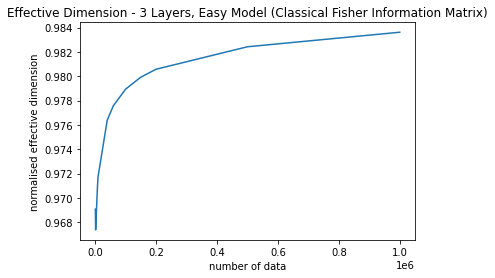

In [19]:
plt.plot(n, effdim)
plt.ylabel("normalised effective dimension")
plt.xlabel("number of data")
plt.title("Effective Dimension - 3 Layers, Easy Model (Classical Fisher Information Matrix)")

In [18]:
np.save("Data/2qubits_3layer_f_hats_pauli.npy", f)
np.save("Data/2qubits_3layer_effective_dimension_pauli.npy", effdim)